In [70]:
using SparseArrays
using LinearAlgebra
using Plots

# paramètres par défaut pour les affichages
default(xlabel='x', ylabel='y', fill=true, lw=0.1, cmap=:seismic, levels=20, fmt=:png)
# color maps: https://docs.juliaplots.org/latest/generated/colorschemes/

# Équations des ondes en 2D

L'objectif de ce notebook / TP est de simuler l'équation des ondes en 2D avec des différences finies. À cet effet, il est séparé en deux parties :

**1/ La discrétisation en espace**

Jusqu'ici, nous n'avons traité que des problèmes unidimensionnels. Ajouter une deuxième dimension rajoute beaucoup de nouveaux problèmes à gérer. On passera donc du temps à s'acclimater aux nouvelles manipulations qui apparaissent et à définir l'opérateur de Laplace pour ce nouveau problème.

**2/ L'équation des ondes**

Une fois la partie en espace maîtrisée, on pourra ajouter la dépendance temporelle et simuler l'équation des ondes. Dans un second temps, on pourra produire une animation pour afficher l'évolution de la solution au cours du temps.

## 1/ Discrétisation en espace

### 1.1. Points de collocation et écriture vectorielle

Ici, on considère des domaines de la forme $(x,y) \in (0, L_x) \times (0, L_y)$ et des points de collocation de type Neumann :
$$ x_j = (j - 1/2) \Delta x, \qquad y_i = (i-1/2) \Delta y $$
avec $j \in \{1, ..., N_x\}$ et $i \in \{1, ..., N_y\}$, ainsi que les pas de maillage $\Delta x = \frac{L_x}{N_x}$ et $\Delta y = \frac{L_y}{N_y}$.

Pour une fonction $(x,y) \mapsto u(x,y)$, on associe la discrétisation 
$$ u_{i,j} \approx u(x_j, y_i) $$
avec $U = (u_{i,j})_{\substack{1 \leq i \leq N_y \\ 1 \leq j \leq N_x}}$ une matrice.

**/!\ Attention** 

La première coordonnée en espace $x$ est en colonne (indexée par $j$), et la seconde $y$ est en ligne (indexée par $i$) ! Ce choix peut sembler bizarre, mais c'est la convention choisie pour l'affichage avec `heatmap` ou `contour` (et aussi en Python avec `numpy.meshgrid`, etc...).

In [71]:
struct MeshGrid
    x::Vector{Float64}
    y::Vector{Float64}
    dx::Float64
    dy::Float64
    Nx::Int64
    Ny::Int64
end

Base.getindex(mesh::MeshGrid, i::Int, j::Int) = (mesh.x[j], mesh.y[i])

function MeshGrid(Lx, Ly, Nx, Ny)
    x, y = range(0.0, Lx, length=Nx+1), range(0.0, Ly, length=Ny+1)
    dx, dy = step(x), step(y)
    x, y = x[2:end] .- 0.5*dx, y[2:end] .- 0.5*dy
    return MeshGrid(x, y, dx, dy, Nx, Ny)
end

MeshGrid

**L'écriture vectorielle**

$$ 
w = \begin{bmatrix} u_{{\bullet}, 1} \\ \vdots \\ u_{\bullet, N_x} \end{bmatrix} 
\qquad\text{avec}\qquad
u_{\bullet, j} = \begin{pmatrix} u_{1,j} \\ \vdots \\ u_{N_y, j} \end{pmatrix}
$$
Les crochets indiquent une notation par blocs alors que les parenthèses indiquent une notation par coefficients.

On peut passer de `w` à `u` et réciproquement avec `u = reshape(w, Ny, Nx)` et `w = reshape(u, Nx*Ny)`. On a également
$$
w_k = u_{i,j} \qquad\text{avec}\quad k = i + (j-1) N_y, \quad\text{ou}\quad \begin{cases} i = (k-1) \% N_y + 1 \\ j = \lfloor (k-1) / N_y \rfloor + 1 . \end{cases}
$$
On peut utiliser `k = i + (j-1)*Nx` et `j, i = divrem(k-1, Ny) .+ 1`.

**/!\ Attention** 

Le comportement de `reshape` varie d'un langage à l'autre. Par exemple en Julia `reshape([1,2,3,4], 2, 2) == [1 3; 2 4]` alors qu'en Python, `np.reshape([1,2,3,4], (2,2)) == [[1,2],[3,4]]`. Julia remplit colonne par colonne alors que Python remplit ligne par ligne. Ainsi, en Python, la relation entre $k$ et $(i,j)$ sera différente.

In [72]:
Base.length(mesh::MeshGrid) = mesh.Nx * mesh.Ny

function Base.getindex(mesh::MeshGrid, k::Int)
    j, i = divrem(k-1, mesh.Ny) .+ 1
    return mesh[i,j]
end

# Permet d'appeler f.(g) pour appliquer xy ↦ f(xy) à tous les points de la grille.
# /!\ ce n'est pas une fonction (x,y) ↦ f(x,y) mais une fonction xy ↦ f(xy) 
#     qui prend en entrée un Tuple
Base.iterate(mesh::MeshGrid, state=1) = state > length(mesh) ? nothing : (mesh[state], state+1)

On peut alors afficher des fonctions connues plutôt facilement. Par exemple, voici un code pour afficher la fonction
$$ f: (x,y) \mapsto e^{-(x^2 + y^2)/5} \cos(2\pi x) \sin(2\pi y)^2, \qquad (x,y) \in (0,5) \times (0,3) $$
avec $500 \times 300$ points de collocation.

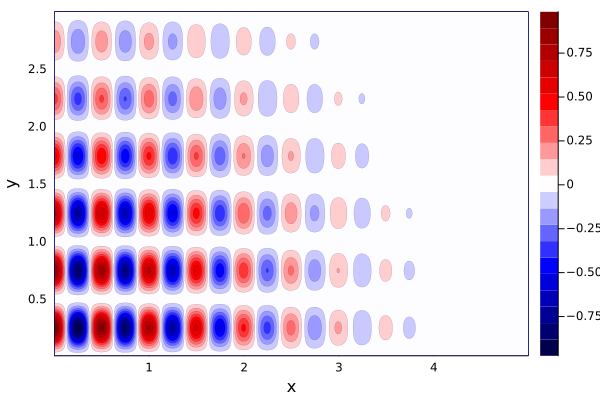

In [73]:
f(x,y) = exp(-0.2 * (x^2 + y^2)) * cos(4π*x) * sin(2π*y)^2
f(xy) = f(xy...) # extension de la fonction aux arguments Tuple

mesh = MeshGrid(5.0, 3.0, 500, 300)
f_vals = f.(mesh)

contour(mesh.x, mesh.y, reshape(f_vals, mesh.Ny, mesh.Nx))

### 1.2. Définition du laplacien discret

**1.2.a)** Dans le cas général $1 < i < N_x$ et $1 < j < N_y$, traduire les approximations de $-\frac{\partial^2 u}{\partial x^2}$ et de $-\frac{\partial^2 u}{\partial y^2}$ en fonction de $w$, i.e. traduire les termes
$$ 2u_{i,j} - u_{i,j-1} - u_{i,j+1} \qquad\text{et}\qquad 2u_{i,j} - u_{i-1,j} - u_{i+1,j} $$
avec les coefficients de $(w_k)_{1 \leq k \leq N_x N_y}$. Pour quels indices $k$ est-ce que cette expression n'est pas valide à cause du bord ?

**1.2.b)** Justifier que la matrice $A_x$ telle que $A_x w$ représente $\begin{cases} 2u_{i,j} - u_{i+1,j} - u_{i-1,j}, \\ u_{0,j} = u_{1,j}, \\ u_{N_y+1,j} = u_{N_y,j}, \end{cases}$ est tridiagonale par bloc, avec $i \in \{1, ..., N_y\}$ et $j \in \{1, ..., N_x\}.$ Pareillement, justifier que la matrice $A_y$ telle que $A_y w$ représente $\begin{cases} 2u_{i,j} - u_{i,j+1} - u_{i,j-1},  \\ u_{i,0} = u_{i,1}, \\ u_{i, N_x+1} = u_{i, N_x}, \end{cases}$ est diagonale par bloc. 

Spécifiquement, déterminer les vecteurs $d_b, d_x, b_x$ de taille $N_y$ et la matrice $P_y \in \mathbb{R}^{N_y \times N_y}$ telles que
$$
A_x = \begin{bmatrix} D_b & B_x & & \\ B_x & D_x & B_x \\ & \ddots & \ddots & \ddots \\ & & B_x & D_x & B_x \\ & & & B_x & D_b \end{bmatrix} , \qquad A_y = \begin{bmatrix} P_y \\ & \ddots & \\ & & P_y \end{bmatrix} .
$$
avec $D_b = {\rm diag}(d_b)$, $D_x = {\rm diag}(d_x)$ et $B_x = {\rm diag}(b_x)$.

**1.2.c)** À la lumière de ces réflexions, compléter la fonction `poisson_matrices` ci-dessous.

In [88]:
"""
    poisson_matrices(Nx, Ny)

Construit les matrices Ax et Ay de la discrétisation de l'opérateur de Laplace en 2D.
"""
function poisson_matrices(Nx, Ny)
    db, dx, bx = ones(Ny), ones(Nx-2) .* -1.0, ones(Nx-1) .* 2.0

    diag_A = vcat(db, repeat(dx, Nx-2), db)
    ldiag_A = repeat(bx, Nx-1)
    udiag_A = repeat(bx, Nx-1)
    Ax = spdiagm(-1 => ldiag_A, 0 => diag_A, 1 => udiag_A)

    Py = ones(Nx)
    Ay = blockdiag((sparse(Py) for _ in 1:Nx)...)

    return Ax, Ay
end

poisson_matrices

**1.2.d)** Vérifier que la forme et les dimensions obtenues sont correctes ci-dessous. Comme toujours, cette vérification doit être active ! Combien de blocs y a-t-il ? Quelle est leur taille ? Est-ce qu'ils sont bien séparés ? Est-ce que leur contenu est correct ?

In [89]:
Ax, Ay = poisson_matrices(4, 3)
display(Ax)
display(Ay)

UndefVarError: UndefVarError: `full` not defined

**📝 Remarque** 

Si on considère la matrice $U = (u_{i,j})_{\substack{1 \leq i \leq N_y \\ 1 \leq j \leq N_x}}$, on pourrait calculer $u_{i-1,j} + u_{i+1,j} - 2u_{i,j}$ avec une multiplication à gauche $P_y U$, et $u_{i,j-1} + u_{i,j+1} - 2u_{i,j}$ avec une multiplication à droite $U P_x^{\sf T}$. Néanmoins, la manipulation d'indices ci-dessus est très courante et il est utile de la pratiquer : beaucoup de solveurs préfèrent manipuler des vecteurs que des matrices.

#### 1.3. Validation du laplacien discret

Pour valider ces implémentations, on considère la fonction
$$ g: (x,y) \mapsto \cos(2\pi x) \cos(4\pi y), \qquad (x,y) \in (0,3) \times (0, 2) $$

**Note :** Cette fonction vérifie bien $\partial_x u(0, y) = \partial_x u(L_x, y) = 0$ et $\partial_y u(x, 0) = \partial_y u(x, L_y) = 0$.

**1.3.a)** Quel est la relation entre $-\partial^2 u / \partial x^2$ et $u$ ? De même, entre $-\partial^2 u / \partial y^2$ et $u$ ?

**1.3.b)** Utiliser cette relation pour compléter le code ci-dessous. La variable `d2x_w` représente l'approximation numérique de $-\partial^2 u / \partial x^2$ sous forme vectorielle. Pareil pour `d2y_w` avec $y$ à la place de $x$.

In [76]:
mesh = MeshGrid(2.0, 1.5, 600, 1000) 
# en utilisant de différents Lx & Ly, ainsi que Nx & Ny, on évite les erreurs de symétrie

g(x,y) = cos(2π*x) * cos(4π*y)
g(xy) = g(xy...)

g_vals = g.(mesh)
Ax, Ay = poisson_matrices(mesh.Nx, mesh.Ny)

d2x_g = #TODO
d2y_g = #TODO
err_x = #TODO
err_y = #TODO

println("Erreur sur d^2 u / dx^2: $(norm(err_x) * sqrt(mesh.dx * mesh.dy))")
println("Erreur sur d^2 u / dy^2: $(norm(err_y) * sqrt(mesh.dx * mesh.dy))")

MethodError: MethodError: no method matching blockdiag(::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64}, ::SparseVector{Float64, Int64})

**1.3.c)** Tracer l'erreur (absolue) sur $\frac{\partial^2 u}{\partial x^2}$ et $\frac{\partial^2 u}{\partial y^2}$ avec les codes ci-dessous. Est-ce que cela semble cohérent ?

In [77]:
contour(mesh.x, mesh.y, reshape(err_x, mesh.Ny, mesh.Nx))

UndefVarError: UndefVarError: `err_x` not defined

In [78]:
contour(mesh.x, mesh.y, reshape(err_y, mesh.Ny, mesh.Nx))

UndefVarError: UndefVarError: `err_y` not defined

## 2/ Équation des ondes

On regarde désormais l'équation des ondes, un problème de la forme, pour $(x,y) \in (0,L_x) \times (0,L_y)$ et $t > 0$, 
$$
\frac{\partial^2 u}{\partial t^2}(x,y,t) - \frac{\partial^2 u}{\partial x^2} - \frac{\partial^2 u}{\partial y^2} = 0 ,
$$
$$
{\rm (CB)}\quad \begin{cases} 
\partial_x u(0, y, t) = \partial_x u(L_x, y, t) = 0 , \\
\partial_y u(x, 0, t) = \partial_y u(x, L_y, t) = 0 , \\
\end{cases}
\qquad\quad
{\rm (CI)}\quad
\begin{cases} 
u(x,y,0) = v_0(x,y), \\ 
\partial_t u(x,y,0) = v_1(x,y) .
\end{cases}
$$

### 2.1. Méthode numérique

On calcule une solution numérique $W^n$ qui est la matrice $U_{i,j}^n \approx u(x_j, y_i, n\Delta t)$ sous forme vectorielle. Pour cela, on commence par calculer des vecteurs $V_0$ et $V_1$ qui représentent $\bigl( v_0(x_j, y_i) \bigr)_{i,j}$ et $\bigl( v_1(x_j, y_i) \bigr)_{i,j}$ respectivement, puis on pose
$$ 
\begin{cases}
W^0 = V_0 , \\
W^{-1} = W^0 - \Delta t V_1 - \frac{1}{2} \left( \beta_x^2 A_x + \beta_y^2 A_y \right) W^0 ,
\end{cases}
$$
Ensuite, on utilise la relation de récurrence
$$ W^{n+1} = (2{\rm id} - \beta_x^2 A_x - \beta_y^2 A_y ) W^n - W^{n-1} $$

**Implémenter** cette méthode ci-dessous avec la fonction `simulate_wave` qui prend en entrée des fonctions `v0` et `v1`, ainsi qu'une grille `mesh`, un temps final `T` et un nombre de pas de temps `Nt`.
On pourra utiliser la syntaxe `mul!(y, A, x, α, β)` qui effectue `y = α*A*x + β*y` sans allocations.
Par exemple, plutôt qu'écrire `y += A*x`, on utiliserait `mul!(y, A, x, 1.0, 1.0)`.

In [79]:
function simulate_waves(v0, v1, mesh, T, Nt)
    dt = T / Nt
    # calcul des matrices utils à la simulation

    # initialisation de la solution

    # boucle du schéma numérique

    return w
end

simulate_waves (generic function with 1 method)

### 2.2. Validation qualitative

On considère désormais les conditions initiales
$$ 
v_0(x,y) = \exp \left( \frac{(x - \mu_x)^2 + (y - \mu_y)^2}{2\sigma^2} \right), \qquad
v_1(x,y) = 0
$$
avec $\mu_x = 0.5$, $\mu_y = 0.4$ et $\sigma = 0.01$, ainsi que le domaine $(x,y) \in (0,1.5) \times (0,1)$.

**2.2.a)** Implémenter ces fonctions $v_0$ et $v_1$.

**2.2.b)** Calculer une solution numérique jusqu'à un temps $T = 0.3$ avec $500$ pas de temps, sur une grille de taille $500 \times 400$.

**2.2.c)** Afficher la solution ainsi calculée et s'assurer que le front d'onde se propage bien de manière circulaire avec une vitesse d'environ 1.

**2.2.d)** Calculer la solution à un temps $T = 2.5$ avec $2500$ pas de temps sur une grille $900 \times 600$.

### 2.3. Un peu d'animation

Jusqu'ici, les méthodes qu'on a implémentées calculent seulement une solution à un temps final. Pour faire une animation, ces méthodes sont inefficaces, puisqu'on ne peut pas utiliser la solution à un temps $t_1$ pour calculer la solution à un temps $t_2 > t_1$. Il faut recalculer tous les pas de temps de $t = 0$ jusqu'à $t = t_2$.

Dans cette partie, on implémente une structure `WaveProblem` qui contiendra la solution `w` à un certain temps `t` et qu'on pourra incrémenter au temps `t + dt` avec une méthode `step!`.

In [84]:
struct WaveProblem
    w::Vector{Float64}
    w_prev::Vector{Float64}
    w_next::Vector{Float64}
    S::SparseMatrixCSC{Float64,Int64}
    t::Base.RefValue{Float64}
    dt::Float64
end

**2.3.a)** Définir la fonction d'initialisation `WaveProblem` ci-dessous.

In [85]:
function WaveProblem(v0::Function, v1::Function, mesh::MeshGrid, dt::Float64)
    # calcul des matrices utiles à la simulation
    #TODO

    # initialisation de la solution
    #TODO

    return WaveProblem(w, w_prev, w_next, S, Ref(0.0), dt)
end

WaveProblem

**2.3.b)** Définir la fonction d'évolution d'un pas de temps `step!` ci-dessous.

In [86]:
"Effectue une itération du schéma saute-mouton."
function step!(pb::WaveProblem)
    # calcul de w_next
    #TODO

    # mise à jour de w_prev et w
    #TODO

    # mise à jour de t
    pb.t[] += pb.dt
end

step!

**2.3.c)** Le code suivant simule le problème sur une grille $300 \times 200$ avec un pas de temps $\Delta t = 2\cdot 10^{-3}$. On enregistre ensuite une animation jusqu'à un temps $T = 2$ avec une image tous les 10 pas de temps. Enjoy!

In [87]:
using Printf

mesh = MeshGrid(1.5, 1.0, 300, 200)
pb = WaveProblem(v0, v1, mesh, 0.002)

n_frames = 101
n_step = 10
clims=(-0.06, 0.06)

anim = @animate for i in 1:n_frames
    if i > 1
        @inbounds for _ in 1:n_step
            step!(pb)
        end
    end
    title = @sprintf("t = %1.2f", pb.t[])
    contour(mesh.x, mesh.y, reshape(pb.w, mesh.Ny, mesh.Nx), clims=clims, title=title)
end

mp4(anim, "wave.mp4", fps=30);

UndefVarError: UndefVarError: `v0` not defined